In [15]:
import pandas as pd 

order = ['MSP', 'Energy', 'MaxLogit', 'Entropy', 'Mahalanobis', 'ViM', 'Ensemble', 'Logic-only', 'Logic-only-OE', 'Logic-based', 'Logic-based-OE']

result_df = pd.read_csv("results_with_logic_only.csv")
del result_df["Unnamed: 0"]

print((result_df.groupby(by=["Method", "Seed"]).mean() * 100).groupby("Method").agg(["mean", "sem"]).reindex(order).to_latex(float_format="%.2f").replace("& 0.", "& $\pm$ 0."))



\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95TPR} \\
{} &  mean &  sem &    mean &  sem &     mean &  sem &     mean &  sem \\
Method         &       &      &         &      &          &      &          &      \\
\midrule
MSP            & 98.37 & $\pm$ 0.05 &   99.81 & $\pm$ 0.01 &    88.31 & $\pm$ 0.19 &     7.94 & $\pm$ 0.19 \\
Energy         & 99.45 & $\pm$ 0.03 &   99.95 & $\pm$ 0.00 &    93.31 & $\pm$ 0.16 &     2.26 & $\pm$ 0.12 \\
MaxLogit       & 99.31 & $\pm$ 0.03 &   99.93 & $\pm$ 0.00 &    92.82 & $\pm$ 0.16 &     2.93 & $\pm$ 0.11 \\
Entropy        & 99.12 & $\pm$ 0.03 &   99.91 & $\pm$ 0.00 &    90.78 & $\pm$ 0.18 &     3.86 & $\pm$ 0.09 \\
Mahalanobis    & 96.15 & $\pm$ 0.18 &   99.21 & $\pm$ 0.04 &    84.35 & $\pm$ 0.73 &    16.39 & $\pm$ 0.87 \\
ViM            & 98.33 & $\pm$ 0.08 &   99.63 & $\pm$ 0.02 &    94.28 & $\pm$ 0.22 &     6.18 & $\pm$ 0.28 \\
Ensemble 

In [2]:
import torch 


cache = torch.load("../data/models/0/cache.pt", map_location="cpu")

In [3]:
from pytorch_ood.detector import MaxSoftmax

def _get_detector_score(x):
    n_samples = x[0].shape[0]

    # calc ensemble scores
    scores = torch.zeros(size=(n_samples,))

    for feature in x:
        scores += MaxSoftmax.score(feature)

    return scores / len(x)

In [42]:
from detectors import PrimateNetLogicDetector
from pytorch_ood.utils import is_known
import seaborn as sb 
import matplotlib.pyplot as plt 

sb.set(style="white", font_scale=1.2)

 


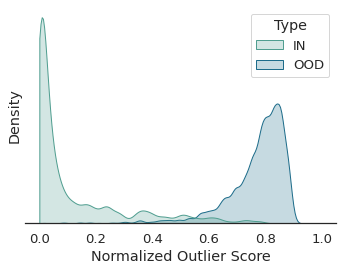

In [43]:
from pytorch_ood.detector import MaxSoftmax 

logits = cache.dataset_all_logits["ImageNetO"]
oe_logits = cache.dataset_oe_logits["ImageNetO"]
ys = cache.dataset_labels["ImageNetO"][0].cpu()

scores = MaxSoftmax.score(logits[0])


df = pd.DataFrame({"Scores": scores.numpy() + 1, "label": ys})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

fig, ax = plt.subplots(figsize=(5,4))

# , 
sb.kdeplot(data=df, x="Scores", common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.1, clip=[0,1]) # , palette="crest" # , ,
sb.move_legend(ax, "upper right")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()

plt.savefig("/home/ki/primatenet-msp.pdf", bbox_inches="tight")

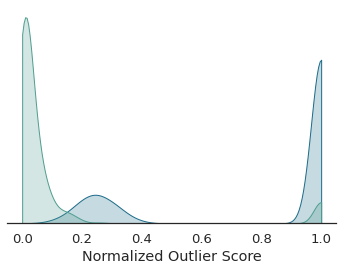

In [51]:

detector = PrimateNetLogicDetector(models=[], oe_model=None)

logits = cache.dataset_all_logits["ImageNetO"]
oe_logits = cache.dataset_oe_logits["ImageNetO"]
ys = cache.dataset_labels["ImageNetO"][0].cpu()

scores = _get_detector_score(logits)
# scores += scores.min()
# scores /= scores.max()
y_hat, world_models = detector._get_world_models(logits)
consistent = detector._check_consistency(y_hat, world_models)

# oe_consistent = oe_logits.argmax(dim=1).long() # assuming positive class is one 
consistent = consistent # & oe_consistent.cpu()
        
total = scores * consistent + 1 

df = pd.DataFrame({"Scores": total.numpy(), "label": ys})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

fig, ax = plt.subplots(figsize=(5,4))

# , 
sb.kdeplot(data=df, x="Scores", common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.1, clip=[0,1], legend=False) # , palette="crest" # , ,
plt.ylabel("")
# sb.move_legend(ax, "upper right")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()


plt.savefig("/home/ki/primatenet-logic.pdf", bbox_inches="tight")

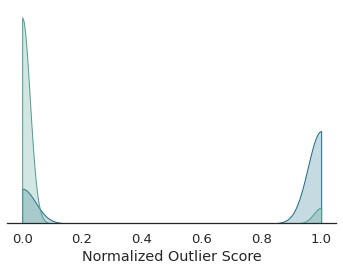

In [52]:
from importlib import reload
import detectors
reload(detectors)

from detectors import PrimateNetLogicOnlyDetector

detector = PrimateNetLogicOnlyDetector(models=[], oe_model=None)

logits = cache.dataset_all_logits["ImageNetO"]
oe_logits = cache.dataset_oe_logits["ImageNetO"]
ys = cache.dataset_labels["ImageNetO"][0].cpu()

consistent = detector._check_consistency(y_hat, world_models)
total = (1-consistent).float()

df = pd.DataFrame({"Scores": total.numpy(), "label": ys})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

fig, ax = plt.subplots(figsize=(5,4))

# , 
sb.kdeplot(data=df, x="Scores", common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.1, clip=[0,1], legend=False) # , palette="crest" # , ,
plt.ylabel("")
# sb.move_legend(ax, "upper right")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()

plt.savefig("/home/ki/primatenet-logic-only.pdf", bbox_inches="tight")

<ipython-input-6-9d410bd5ddb0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "Wrong"


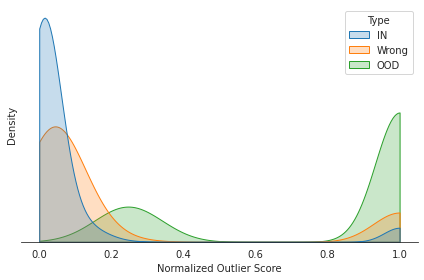

In [6]:
sb.set_style("white")

df = pd.DataFrame({"Scores": total.numpy(), "label": ys, "predicted": y_hat})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "Wrong"
# df["Type"][(~is_known(ys)).numpy()] = "OOD"


fig, ax = plt.subplots(figsize=(6,4))

# , 
sb.kdeplot(data=df, x="Scores", common_norm=False, fill=True, hue="Type", bw_method=0.2, clip=[0,1]) # , palette="crest" # , ,
sb.move_legend(ax, "upper right")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()


<ipython-input-7-af615d29dea7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "Wrong"


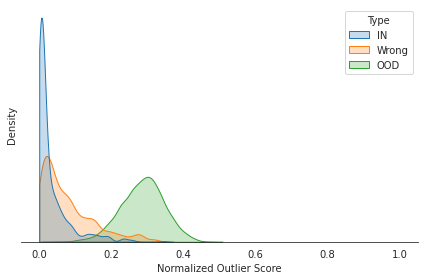

In [7]:
sb.set_style("white")

df = pd.DataFrame({"Scores": scores + 1, "label": ys, "predicted": y_hat})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "Wrong"
# df["Type"][(~is_known(ys)).numpy()] = "OOD"


fig, ax = plt.subplots(figsize=(6,4))

# , 
sb.kdeplot(data=df, x="Scores", common_norm=False, fill=True, hue="Type", bw_method=0.2, clip=[0,1]) # , palette="crest" # , ,
sb.move_legend(ax, "upper right")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()


In [8]:
# plt.hist(total.numpy())

In [9]:
consistent

tensor([1, 1, 1,  ..., 0, 0, 0])

In [10]:
from pytorch_ood.utils import OODMetrics

# m = OODMetrics()
# m.update(-consistent.float(), ys)
# m.compute()

In [11]:
from pytorch_ood.detector import MaxSoftmax, EnergyBased

# def _get_detector_score(x):
#     n_samples = x[0].shape[0]

#     # calc ensemble scores
#     # scores = torch.zeros(size=(n_samples,))

#     scores = MaxSoftmax.score(x[0])

#     return scores

# detector = PrimateNetLogicDetector(models=[], oe_model=None)

# logits = cache.dataset_all_logits["ImageNetO"]
# oe_logits = cache.dataset_oe_logits["ImageNetO"]
# ys = cache.dataset_labels["ImageNetO"][0].cpu()

# scores = _get_detector_score(logits)
# # scores += scores.min()
# # scores /= scores.max()
# y_hat, world_models = detector._get_world_models(logits)
# consistent = detector._check_consistency(y_hat, world_models)

# # oe_consistent = oe_logits.argmax(dim=1).long() # assuming positive class is one 
# consistent = consistent # & oe_consistent.cpu()
        
# total = scores * consistent + 1 

# m = OODMetrics()
# m.update(total, ys)
# m.compute()

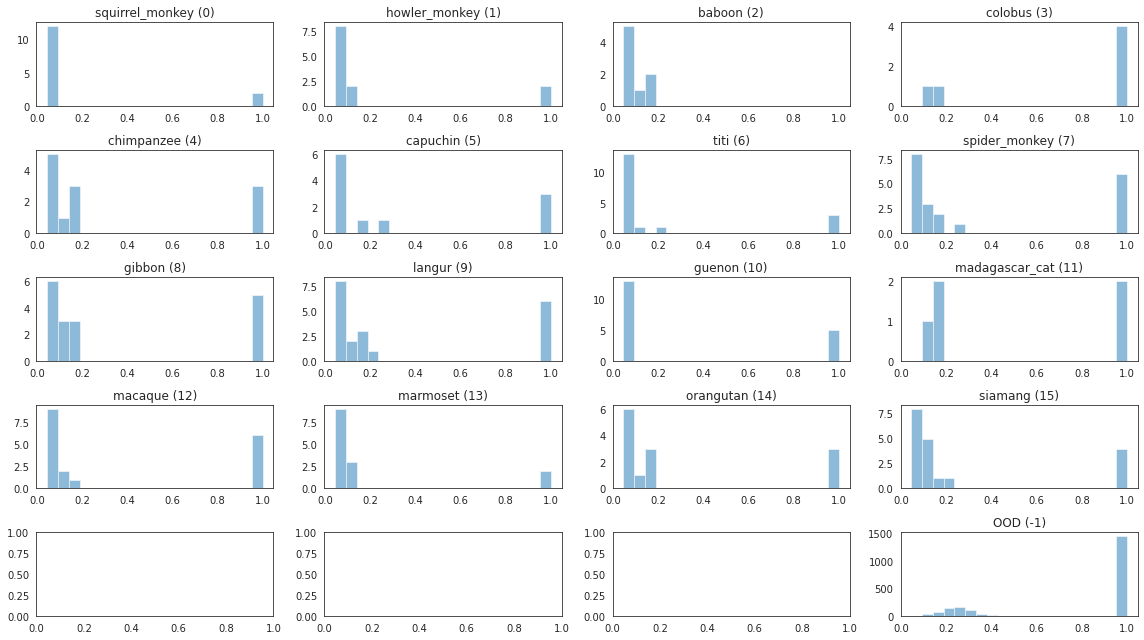

In [13]:
from primatenet import PrimateNet

class_idx_to_name = {i[1]: i[0] for i in PrimateNet.data.values()}
# class_idx_to_name.update({-1: "OOD"})

fig, axs = plt.subplots(5,4, figsize=(16,9))

axs = axs.flatten()

bins = 20 

known = ys >= 0 

for clazz in ys.unique():
    idx = ys == clazz
    
    _, bins, _ = axs[clazz].hist(total[idx].numpy(), alpha=0.5, bins=bins) # , range=[0, 1]
    name = class_idx_to_name[clazz.item()] if clazz.item() in class_idx_to_name else "OOD"
    axs[clazz].set_title(f"{name} ({clazz.item()})")
    
    # plt.title(str(clazz))
plt.tight_layout()
plt.show()


In [3]:
import torch 



In [15]:
from pytorch_ood.utils import is_known

res = []

for i in range(10):
    cache = torch.load(f"../data/models/{i}/cache.pt", map_location="cpu")
    logits = cache.dataset_all_logits["ImageNetO"][0]
    ys = cache.dataset_labels["ImageNetO"][0]
    
    known = is_known(ys) 
    
    err = 1 - (logits[known].argmax(dim=1) == ys[known]).long().sum() / known.long().sum()
    res.append(err)

FileNotFoundError: [Errno 2] No such file or directory: '../data/models/1/cache.pt'

In [14]:
import numpy as np 

np.array(res)

array([0.14625001, 0.14625001, 0.14625001, 0.14625001, 0.14625001,
       0.14625001, 0.14625001, 0.14625001, 0.14625001, 0.14625001],
      dtype=float32)